# DBSCAN grid search for epsilon and min samples parameters

After running nearest neighbors on a subset of our data, we visually confirm can probably narrow down optimal epsilon to between 0.8-0.9

To make a grid search feasable time wise, we load a subset of our dataset for grid search: 1500 squad2 examples - 300 starting from 10.000,30.000,50.000,70.000,90.000


In [1]:
import cuml
import cudf
import os
import time

In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
from cuml.cluster import KMeans as cuKMeans
from cuml.neighbors import NearestNeighbors
import cupy

In [4]:
from dask_cuda import LocalCUDACluster
import dask_cudf
from dask.distributed import Client
import dask.dataframe as dd
from cuml.dask.cluster.dbscan import DBSCAN as daskDBSCAN

In [5]:
# cluster = LocalCUDACluster()
# client = Client(cluster)

In [6]:
client = Client("tcp://127.0.0.1:37687")
client

Client Scheduler: tcp://127.0.0.1:37687 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 2 Memory: 125.50 GiB


In [7]:
# client

In [7]:
import glob

def pd_read_pattern(pattern):
    files = glob.glob(pattern)

    df = pd.DataFrame()
    for f in files:
        df = df.append(pd.read_csv(f))

    return df.reset_index(drop=True)

In [8]:
# load full partitioned dataset - read in as pandas df,
# for some reason dask cuml dbscan doesn't accept a dask cdDF?
# https://docs.rapids.ai/api/cuml/nightly/api.html?highlight=regression#multi-node-multi-gpu-algorithms
gdf = pd_read_pattern('/rapids/notebooks/host/representations/final/partitions/subset/*.csv')

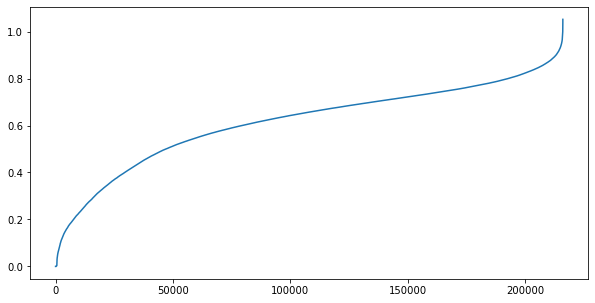

In [20]:
# %matplotlib widget
plt.figure(figsize=(10,5))
nn = NearestNeighbors(n_neighbors=5).fit(gdf)
distances, idx = nn.kneighbors(gdf)
distances = cupy.asnumpy(distances)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

# plt.xticks(np.arange(min(distances), max(distances)+1, 1.0))
plt.plot(distances)

In [12]:

results = pd.DataFrame(columns=['eps','min_samples','n_clusters','n_noise'])

epsilon_range = np.arange(0.80,0.90,0.01)
min_sample_range = range(4,30,6)

for e in epsilon_range:
    for m in min_sample_range:
        eps = e
        min_samples = m
        cuml_dbscan = daskDBSCAN( eps = eps,
                                  metric='euclidean',
                                  min_samples = min_samples,
                                  max_mbytes_per_batch = 10000
                                )

        trained_DBSCAN = cuml_dbscan.fit(gdf)
        labels = trained_DBSCAN.labels_

        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)
        print(f'e: {eps} s: {min_samples} c: {n_clusters_} n: {n_noise_}')

        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters_,
            'n_noise': n_noise_
        }, ignore_index=True)


e: 0.8 s: 4 c: 672 n: 31639
e: 0.8 s: 10 c: 43 n: 40278
e: 0.8 s: 16 c: 19 n: 43566
e: 0.8 s: 22 c: 13 n: 45526
e: 0.8 s: 28 c: 8 n: 46894
e: 0.81 s: 4 c: 515 n: 27025
e: 0.81 s: 10 c: 41 n: 34217
e: 0.81 s: 16 c: 13 n: 37113
e: 0.81 s: 22 c: 6 n: 39034
e: 0.81 s: 28 c: 7 n: 40375
e: 0.8200000000000001 s: 4 c: 390 n: 22987
e: 0.8200000000000001 s: 10 c: 27 n: 28796
e: 0.8200000000000001 s: 16 c: 15 n: 31286
e: 0.8200000000000001 s: 22 c: 9 n: 32855
e: 0.8200000000000001 s: 28 c: 5 n: 34104
e: 0.8300000000000001 s: 4 c: 309 n: 19372
e: 0.8300000000000001 s: 10 c: 17 n: 24079
e: 0.8300000000000001 s: 16 c: 10 n: 26048
e: 0.8300000000000001 s: 22 c: 5 n: 27384
e: 0.8300000000000001 s: 28 c: 8 n: 28444
e: 0.8400000000000001 s: 4 c: 222 n: 16018
e: 0.8400000000000001 s: 10 c: 13 n: 20014
e: 0.8400000000000001 s: 16 c: 4 n: 21587
e: 0.8400000000000001 s: 22 c: 4 n: 22562
e: 0.8400000000000001 s: 28 c: 2 n: 23499
e: 0.8500000000000001 s: 4 c: 178 n: 13130
e: 0.8500000000000001 s: 10 c: 6 n: 1

In [10]:

results__epsilon_0_84 = pd.DataFrame(columns=['eps','min_samples','n_clusters','n_noise'])

min_sample_range = range(4,10,1)


for m in min_sample_range:
    eps = 0.84
    min_samples = m
    cuml_dbscan = daskDBSCAN( eps = eps,
                              metric='euclidean',
                              min_samples = min_samples,
                              max_mbytes_per_batch = 10000
                            )

    trained_DBSCAN = cuml_dbscan.fit(gdf)
    labels = trained_DBSCAN.labels_

    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    print(f'e: {eps} s: {min_samples} c: {n_clusters_} n: {n_noise_}')

    results__epsilon_0_84.append({
        'eps': eps,
        'min_samples': min_samples,
        'n_clusters': n_clusters_,
        'n_noise': n_noise_
    }, ignore_index=True)



e: 0.84 s: 4 c: 222 n: 16018
e: 0.84 s: 5 c: 124 n: 17044
e: 0.84 s: 6 c: 58 n: 17954
e: 0.84 s: 7 c: 49 n: 18529
e: 0.84 s: 8 c: 36 n: 19068
e: 0.84 s: 9 c: 19 n: 19582
